In [1]:
import pandas as pd
import numpy as np
file_path = r'paper_data.xlsx'
data = pd.read_excel(file_path)
# drop the "index" column
data = data.drop('Index', axis=1)

features = data.columns
numeric_features = ['Age','Years of Work Experience','Years of Work Experience at Current Institution', 'Institution Level', 'Number of Children Under 12',
                    'First Degree', 'Highest Degree', 'Monthly Night Shift Frequency', 'Monthly Take-home Income',
                    'Number of Specialist Trainings/Continuing Education Attended', 'Average Number of Clinical Teaching/Training Activities Participated in per Year', 
                    'Degree of Application of Specialist Skills in Subsequent Clinical Practice']
categorical_features = ['Gender', 'Job Title', 'Position', 
            'Employment Type',  
            'Whether Obtained Specialist Qualification Certificate and the Specialist Field',
            'Whether Working in a Specialist Nursing Outpatient Clinic', 
            'Whether Undertaken Research Projects in the Past Three Years', 'Whether Role Stress is High', 
            'Whether Empathy Level is High', 'Whether Level of Happiness is High', 'Whether Satisfaction with Performance Distribution is High']
target = 'In Your Current Medical Institution, Your Inclination to Change Position in the Next 1-10 Years'
# ensure numeric_features is a subset of features
assert(all(elem in features for elem in numeric_features))
# ensure categorical_features is a subset of features
assert(all(elem in features for elem in categorical_features))
# ensure each feature is either in numeric_features or categorical_features, or it is the target
assert(all(elem in numeric_features or elem in categorical_features or elem == target for elem in features))
# ensure there is no duplicates among the three categories
assert(all(elem not in numeric_features for elem in categorical_features))
assert(all(elem not in categorical_features for elem in numeric_features))
assert(target not in numeric_features + categorical_features)

# X is all but target
X = data[numeric_features + categorical_features]
y = data[target]

# Get the feature indices for preprocessing pipeline
numeric_feature_mask = np.isin(X.columns.to_numpy(), np.array(numeric_features))
numeric_feature_indices = np.nonzero(numeric_feature_mask)[0]
categorical_feature_mask = np.isin(X.columns.to_numpy(), np.array(categorical_features))
categorical_feature_indices = np.nonzero(categorical_feature_mask)[0]
assert(len(numeric_feature_indices) == len(numeric_features))
assert(len(categorical_feature_indices) == len(categorical_features))
print(f'Features: {X.columns}')
print(f'Numeric: {numeric_features}')
print(f'Categorical: {categorical_features}')
print(f'Numeric Feature Indices: {numeric_feature_indices}')
print(f'Categorical Feature Indices: {categorical_feature_indices}')




Features: Index(['Age', 'Years of Work Experience',
       'Years of Work Experience at Current Institution', 'Institution Level',
       'Number of Children Under 12', 'First Degree', 'Highest Degree',
       'Monthly Night Shift Frequency', 'Monthly Take-home Income',
       'Number of Specialist Trainings/Continuing Education Attended',
       'Average Number of Clinical Teaching/Training Activities Participated in per Year',
       'Degree of Application of Specialist Skills in Subsequent Clinical Practice',
       'Gender', 'Job Title', 'Position', 'Employment Type',
       'Whether Obtained Specialist Qualification Certificate and the Specialist Field',
       'Whether Working in a Specialist Nursing Outpatient Clinic',
       'Whether Undertaken Research Projects in the Past Three Years',
       'Whether Role Stress is High', 'Whether Empathy Level is High',
       'Whether Level of Happiness is High',
       'Whether Satisfaction with Performance Distribution is High'],
      d

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
print(numeric_feature_indices)
print(categorical_feature_indices)

categorical_transformer = Pipeline(steps=[
     # Although there are no missing values in the collected data, when doing cross validation, it is possible that there are categories in validation set not seen in the training set
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preproc_scale_onehot = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
preproc_scale = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
    ]
)
preproc_onehot = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ]
)
feature_selection = SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear'))
smote = SMOTE()
# X_preprocessed = preprocessor.fit_transform(X)
# print(X_preprocessed)


[ 0  1  2  3  4  5  6  7  8  9 10 11]
[12 13 14 15 16 17 18 19 20 21 22]


In [5]:
import pygame
import time
# Initialize pygame's mixer module
pygame.mixer.init()

# Load a sound file (you need to provide a path to a WAV or OGG file)
sound = pygame.mixer.Sound('ok.wav')

# Set the volume (0.0 to 1.0)
sound.set_volume(0.5)  # Set to 50% volume
def play_finished_hint():
    sound.play()
    time.sleep(0.5)
play_finished_hint()

In [6]:
from sklearn.model_selection import RandomizedSearchCV
import optuna
from optuna import trial as optuna_trial
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
# preproc_steps_scale_select_SMOTE = ImbPipeline(steps=[
#     ('preprocessor', preproc_scale),
#     ('feature_selection', SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear'))),
#     ('smote', SMOTE())
# ])

# just for intellisense purposes
suggest_float = 'suggest_float'
suggest_int = 'suggest_int'
suggest_categorical = 'suggest_categorical'

metric = 'roc_auc'
optuna.logging.set_verbosity(optuna.logging.ERROR)
def cross_validate_model(model_class, hyperparameters, n_trials = 100): # [hyperparameter_name, functionname, (function args)
    def objective(trial: optuna_trial.Trial):
        # Define the pipeline
        adopt_scalar = trial.suggest_categorical('Adopt StandardScalar for numeric features', [True, False])
        adopt_onehot = trial.suggest_categorical('Adopt OneHotEncoder for categorical features', [True, False])
        adopt_selection = trial.suggest_categorical('Adopt feature selection', [True, False])
        adopt_SMOTE = trial.suggest_categorical('Adopt oversampling using SMOTE', [True, False])
        # pipeline steps
        steps = []
        if adopt_scalar and adopt_onehot: steps.append(('onehot_and_scalar', preproc_scale_onehot))
        else:
            if adopt_scalar: steps.append(('scalar', preproc_scale))
            if adopt_onehot: steps.append(('onehot', preproc_onehot))
        if adopt_selection: steps.append(('selection', feature_selection))
        if adopt_SMOTE: steps.append(('smote', smote))
        model_args = {}
        for hyperparameter in hyperparameters:
            parameter_name, function_name, function_args = hyperparameter
            func = getattr(trial, function_name)
            function_kwargs = {'log': True} if function_name == suggest_float else {}
            if function_args[0] == "hidden_layer_sizes":
                function_args[1] = [(num,) for num in function_args[1]]
            model_args.update({parameter_name: func(*function_args, **function_kwargs)})
        model = model_class(**model_args)
        steps.append(('classifier', model))
        pipeline = ImbPipeline(steps=steps)
        # Perform cross-validation
        score = cross_val_score(pipeline, X_train, y_train, n_jobs=-1, cv=10, scoring=metric)
        mean_score = score.mean()
        # print(f"score: {mean_score}")
        return mean_score
    
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=42))  # Use 'minimize' for regression tasks
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True, n_jobs=-1)  # Set the number of trials as needed
    trial = study.best_trial
    print(f'{model_class.__name__} Cross-Validation Performance:')
    print("Best trial:")
    print(f"  Value: {trial.value}")
    print("  Best hyperparameters:")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

In [7]:
hyperparameters=[# [hyperparameter_name, functionname, (function args)
    ('n_estimators', suggest_int, ['n_estimators', 10, 1000]),
    ('max_depth', suggest_int, ['max_depth', 1, 30]),
    ('min_samples_split', suggest_int, ['min_samples_split', 2, 20]),
    ('min_samples_leaf', suggest_int, ['min_samples_leaf', 1, 10]),
    ('max_features', suggest_categorical, ['max_features', ['log2', 'sqrt']])
]
cross_validate_model(RandomForestClassifier, hyperparameters, 100)
play_finished_hint()

  0%|          | 0/100 [00:00<?, ?it/s]

RandomForestClassifier Cross-Validation Performance:
Best trial:
  Value: 0.7061733716475096
  Best hyperparameters:
    Adopt StandardScalar for numeric features: True
    Adopt OneHotEncoder for categorical features: True
    Adopt feature selection: False
    Adopt oversampling using SMOTE: True
    n_estimators: 331
    max_depth: 15
    min_samples_split: 13
    min_samples_leaf: 7
    max_features: sqrt


In [7]:
import xgboost as xgb
hyperparameters=[# [hyperparameter_name, functionname, (function args)
    ('n_estimators', suggest_int, ['n_estimators', 50, 1000]),
    ('max_depth', suggest_int, ['max_depth', 3, 20]),
    ('learning_rate', suggest_float, ['learning_rate', 0.005, 0.2]),
    ('subsample', suggest_float, ['subsample', 0.5, 1.0]),
    ('colsample_bytree', suggest_float, ['colsample_bytree', 0.3, 1.0]),
    # ('tree_method', suggest_categorical, ['tree_method', ['gpu_hist']])
]
cross_validate_model(xgb.XGBClassifier, hyperparameters, 100)
play_finished_hint()

  0%|          | 0/100 [00:00<?, ?it/s]

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\luo20\anaconda3\envs\pubes\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\luo20\anaconda3\envs\pubes\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\luo20\anaconda3\envs\pubes\Lib\site-packages\imblearn\pipeline.py", line 333, in fit
    self._final_estimator.fit(Xt, yt, **last_step_params["fit"])
  File "c:\Users\luo20\anaconda3\envs\pubes\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\luo20\anaconda3\envs\pubes\Lib\site-packages\xgboost\sklearn.py", line 1531, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\luo20\anaconda3\envs\pubes\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\luo20\anaconda3\envs\pubes\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\luo20\anaconda3\envs\pubes\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\luo20\anaconda3\envs\pubes\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:18:02] C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\common\common.h:174: XGBoost version not compiled with GPU support.


In [175]:
from sklearn.neural_network import MLPClassifier
hyperparameters=[# [hyperparameter_name, functionname, (function args)
    ('hidden_layer_sizes', suggest_categorical, ['hidden_layer_sizes', [400, 200, 100, 50, 20, 5]]),
    ('activation', suggest_categorical, ['activation', ['identity', 'logistic', 'tanh', 'relu']]),
    ('solver', suggest_categorical, ['solver', ['lbfgs', 'sgd', 'adam']]),
    ('alpha', suggest_float, ['alpha', 0.0001, 0.01]),
    ('learning_rate', suggest_categorical, ['colsample_bytree',['constant', 'invscaling', 'adaptive']])
]
cross_validate_model(MLPClassifier, hyperparameters, 100)
play_finished_hint()

  0%|          | 0/100 [00:00<?, ?it/s]

MLPClassifier Cross-Validation Performance:
Best trial:
  Value: 0.7328113026819923
  Best hyperparameters:
    Adopt StandardScalar for numeric features: False
    Adopt OneHotEncoder for categorical features: False
    Adopt feature selection: True
    Adopt oversampling using SMOTE: False
    hidden_layer_sizes: 50
    activation: relu
    solver: lbfgs
    alpha: 0.0006522901040729639
    colsample_bytree: invscaling


In [7]:
import lightgbm as lgb
hyperparameters=[# [hyperparameter_name, functionname, (function args)
    ('n_estimators', suggest_int, ['n_estimators', 20, 1000]),
    ('learning_rate', suggest_float, ['learning_rate', 0.01, 0.2]),
    ('num_leaves', suggest_int, ['num_leaves', 31, 100]),
    ('max_depth', suggest_int, ['max_depth', 2, 20]),
    ('min_data_in_leaf', suggest_int, ['min_data_in_leaf', 1, 50]),
    ('boosting_type', suggest_categorical, ['boosting_type', ['gbdt']]),
    ('device', suggest_categorical, ['device', ['gpu']])
]
cross_validate_model(lgb.LGBMClassifier, hyperparameters, 100)
play_finished_hint()

  0%|          | 0/100 [00:00<?, ?it/s]

LGBMClassifier Cross-Validation Performance:
Best trial:
  Value: 0.6820162835249042
  Best hyperparameters:
    Adopt StandardScalar for numeric features: False
    Adopt OneHotEncoder for categorical features: False
    Adopt feature selection: True
    Adopt oversampling using SMOTE: True
    n_estimators: 737
    learning_rate: 0.029494627875723916
    num_leaves: 35
    max_depth: 17
    min_data_in_leaf: 34


In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
hyperparameters=[# [hyperparameter_name, functionname, (function args)
    ('n_estimators', suggest_int, ['n_estimators', 50, 200]),
    ('learning_rate', suggest_float, ['learning_rate', 0.01, 1.0]),
    ('algorithm', suggest_categorical, ['algorithm', ['SAMME']]),
    ('random_state', suggest_categorical, ['random_state', [42]])
]
cross_validate_model(AdaBoostClassifier, hyperparameters, 100)
play_finished_hint()

  0%|          | 0/100 [00:00<?, ?it/s]

AdaBoostClassifier Cross-Validation Performance:
Best trial:
  Value: 0.7025454980842911
  Best hyperparameters:
    Adopt StandardScalar for numeric features: True
    Adopt OneHotEncoder for categorical features: True
    Adopt feature selection: False
    Adopt oversampling using SMOTE: True
    n_estimators: 154
    learning_rate: 0.22739559478532873
    algorithm: SAMME
    random_state: 42


In [9]:
from catboost import CatBoostClassifier
hyperparameters=[# [hyperparameter_name, functionname, (function args)
    ('iterations', suggest_int, ['iterations', 50, 1000]),
    ('learning_rate', suggest_float, ['learning_rate', 0.01, 0.2]),
    ('depth', suggest_int, ['depth', 4, 12]),
    ('l2_leaf_reg', suggest_int, ['l2_leaf_reg', 1, 10]),
    ('early_stopping_rounds', suggest_int, ['early_stopping_rounds', 5, 20]),
    ('verbose', suggest_categorical, ['verbose', [0]]),
    ('task_type', suggest_categorical, ['task_type', ['GPU']]),
    ('devices', suggest_categorical, ['devices', ['1']]) # depends on which GPU on your device is better
]
cross_validate_model(CatBoostClassifier, hyperparameters, 100)
play_finished_hint()

  0%|          | 0/100 [00:00<?, ?it/s]

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


[0.6604053  0.57280175 0.63662209 0.81443741 0.58539442 0.97576013
 0.57015651 0.98894402 0.95323254 0.55550218 0.83936423 0.39742183
 0.94205478 0.61909365 0.76610734 0.90183745 0.41916011 0.97731189
 0.74772735 0.60632852 0.95474777 0.86809228 0.73210243 0.96921338
 0.86242604 0.75515678 0.88559288 0.9398445  0.72987038 0.57873018
 0.81511895 0.95585215 0.90965242 0.12113383 0.62920496 0.89726699
 0.9187172  0.92382858 0.73959653 0.55689315 0.86535953 0.96625302
 0.5951921  0.35443127 0.77282037 0.92488473 0.95279776 0.79638311
 0.58092429 0.74461838 0.76150897 0.55509035 0.96066219 0.88699435
 0.79728488 0.26503322 0.98132407 0.60880661 0.14205264 0.72396631
 0.95507908 0.88974313 0.99013672 0.51569911 0.82889318 0.67217299
 0.94667216 0.78539046 0.82136448 0.75760146 0.95092888 0.83043888
 0.47090189 0.74567533 0.77645712 0.93159896 0.96444845 0.69241819
 0.65202307 0.91553593 0.9348896  0.76060055 0.49309496 0.74590827
 0.7970208  0.75217671 0.89393085 0.50745201 0.97590621 0.7733

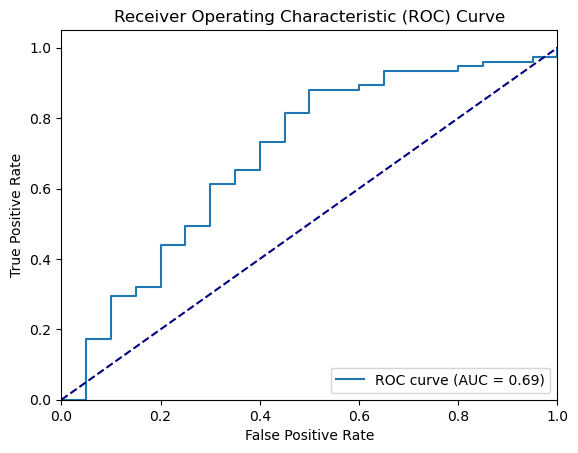

In [16]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
# Use the optimal preprocessing procedures (no feature selection, resample with SMOTE)
smote = SMOTE(random_state=42)
X_train_unselected = X_train
X_train_unselected_resampled, y_train_unselected_resampled = smote.fit_resample(X_train_unselected, y_train)
clf = CatBoostClassifier(verbose=0)

clf.fit(X_train_unselected_resampled, y_train_unselected_resampled)

# Because resampling does not affect the dimensionality of X_test, and we did not select features from X_train, we don't need to modify X_test
# the "[:, 1]" part selectes the probability of a sample to be positive
y_pred_proba = clf.predict_proba(X_test)[:, 1]
print(y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)
print(auc_score)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Step 6: Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
